In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji
from num2words import num2words

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from chart_studio.plotly import plot, iplot


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

from keras.models import Sequential

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from keras.optimizers import Adam

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.manifold import TSNE
from keras.layers import Dense, Embedding, SpatialDropout1D, Dropout, Conv1D
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
from keras.layers import LSTM, Bidirectional, GRU, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D

from keras import layers
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from bs4 import BeautifulSoup

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import brown,words
from nltk.tag import pos_tag
from textblob import TextBlob

import torch
import transformers as ppb
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.decomposition import PCA
import tokenization


from xgboost import XGBClassifier
from gensim.models import KeyedVectors
import eli5
import bert
import re, string
from string import punctuation
from sklearn.decomposition import PCA
from scipy.linalg import svd as scipy_svd

pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 8
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


# Funciones Generales

In [3]:
CODE_LOCATION = {'al': 'alabama',
  'ak': 'alaska',
  'az': 'arizona',
  'ar': 'arkansas',
  'ca': 'california',
  'co': 'colorado',
  'ct': 'connecticut',
  'de': 'delaware',
  'dc': 'district of columbia',
  'fl': 'florida',
  'ga': 'georgia',
  'hi': 'hawaii',
  'id': 'idaho',
  'il': 'illinois',
  'in': 'indiana',
  'ia': 'iowa',
  'ks': 'kansas',
  'ky': 'kentucky',
  'la': 'louisiana',
  'me': 'maine',
  'md': 'maryland',
  'ma': 'massachusetts',
  'mi': 'michigan',
  'mn': 'minnesota',
  'ms': 'mississippi',
  'mo': 'missouri',
  'mt': 'montana',
  'ne': 'nebraska',
  'nv': 'nevada',
  'nh': 'new hampshire',
  'nj': 'new jersey',
  'nm': 'new mexico',
  'ny': 'new york',
  'nc': 'north carolina',
  'nd': 'north dakota',
  'oh': 'ohio',
  'ok': 'oklahoma',
  'or': 'oregon',
  'pa': 'pennsylvania',
  'ri': 'rhode island',
  'sc': 'south carolina',
  'sd': 'south dakota',
  'tn': 'tennessee',
  'tx': 'texas',
  'ut': 'utah',
  'vt': 'vermont',
  'va': 'virginia',
  'wa': 'washington',
  'wv': 'west virginia',
  'wi': 'wisconsin',
  'wy': 'wyoming',
  'as': 'american samoa',
  'gu': 'guam',
  'mh': 'marshall islands',
  'fm': 'micronesia',
  'mp': 'northern marianas',
  'pw': 'palau',
  'u.s.a': 'united states',
  'usa': 'united states',
  '304': 'west virginia',
  'd.c': 'district of columbia',
  'd.c.': 'district of columbia',                 
  'us': 'united states',
  'ny': 'new york',
  'nyc': 'new york',
  'uk': 'united kingdom',
  'u.k': 'united kingdom',
  'u.k.': 'united kingdom',
  'bc': 'british columbia',
  'ab': 'alberta',
  'vi': 'virgin islands'}




#Imprimir metricas de las predicciones
def mostrar_metricas(y_test, y_pred):
    print('Reporte de clasificación: \n', classification_report(y_test, y_pred))
    print('Matriz de confusión: \n',confusion_matrix (y_test, y_pred))
    print('ROC: \n', metrics.roc_auc_score(y_test, y_pred))

    # Obtener y reformar la matriz de datos de 
    matrix = confusion_matrix (y_test, y_pred) 
    matrix = matrix.astype ('float') / matrix.sum (axis = 1) [:, np.newaxis] 

    # Build the plot
    plt.figure()
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},cmap=plt.cm.Greens, linewidths=0.2)
    plt.xlabel('Predicción')
    plt.ylabel('Target')
    plt.title('Matriz de confusión')
    plt.show()
    
def grafico_pie(df, titulo, valores, etiquetas):
    fig = px.pie(df, values=valores, names=etiquetas)
    fig.update_layout(title_text=titulo,
                      template="plotly_white")
    fig.show()
    
def grafico_distr(df, columna, titulo, xtitulo, ytitulo):
    x1 = df.loc[df['target'] == 1][columna]
    x2 = df.loc[df['target'] == 0][columna]
    group_labels = ['Verdadero', 'Falso']
    colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
    fig = ff.create_distplot([x1, x2], group_labels,colors=colors)
    fig.update_layout(title_text=titulo,
                      xaxis_title=xtitulo,
                      yaxis_title=ytitulo,
                      template="plotly_white")
    fig.show()
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


def resultados(pred, test_df):
    res_df=pd.DataFrame(test_df['id'])
    res_df['target']=pred
    res_df.to_csv('data/submission.csv', index=False)
    
def dict_vocabulario(x):
    tweets = x.apply(lambda s: s.split()).values
    vocab = {}
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1 #Si ya existe en el diccionario
            except KeyError:
                vocab[word] = 1  #Si no existe
    return vocab


def porcentaje_cobertura(x, embeddings):
    vocab = dict_vocabulario(x)
    cubiertos = {}
    no_cubiertos = {}
    cant_cubiertos = 0
    cant_no_cubiertos = 0
    for word in vocab:
        try:
            cubiertos[word] = embeddings[word]
            cant_cubiertos += vocab[word]
        except:
            no_cubiertos[word] = vocab[word]
            cant_no_cubiertos += vocab[word]

    palabras_cubiertas_pct = len(cubiertos) / len(vocab)
    texto_cubierto_pct = (cant_cubiertos/ (cant_cubiertos + cant_no_cubiertos))
    return no_cubiertos, palabras_cubiertas_pct, texto_cubierto_pct

stops = set(stopwords.words('english'))
#punctuation = list(string.punctuation)
punctuation = '!"$%&\()*+,-/:;<=>?[\\]“”^_`#{|}~’'


word_list = brown.words()
word_set = set(word_list)


def unir_texto(text):
    return ( ' '.join(text))

def eliminar_palabras_con(text, con):
    palabras = []
    for word in text.split():
        if con not in word:
            palabras.append(word)
    return unir_texto(palabras)


# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
englishStemmer=SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#Elimino stops words 
def eliminar_sw(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stops: 
            #pos = pos_tag([i.strip()])
            #word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(i.strip())
    return unir_texto(final_text)

def lematizar(text):
    final_text = []
    for i in text.split():
        pos = pos_tag([i.strip()])
        word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
        final_text.append(word)
    return unir_texto(final_text)

def minusculas(text):
    return text.lower()

def eliminar_nums(text):
    cadena = []
    for x in text:
         if x not in string.digits:
                cadena.append(x)
    return  ''.join(cadena)

def eliminar_punct(text):
    cadena = []
    for x in text:
         if x not in punctuation:
                cadena.append(x)
    return  ''.join(cadena)
        
def eliminar_espacios_multiples(text):
    text = re.sub(r"\s+"," ", text, flags = re.I)
    return text.strip()

def eliminar_palabras_con_numeros(text):
    return re.sub(r'\w*\d\w*', '', text).strip()

def convertir_location_code(text):
    cadena = []
    for word in text.split():
        if word in CODE_LOCATION:
            word = CODE_LOCATION[word]
        cadena.append(word)
    return  ' '.join(cadena)

def reemplazar_chars_primer(text):
    text = text.replace('mediterran...','mediterranean') 
    text = text.replace('&amp;','and')
    text = text.replace('&gt;&gt;',' view ')
    text = text.replace('&gt;',' ')
    text = text.replace('&lt;',' ')
    text = text.replace('mph','miles per hour')
    text = text.replace('rcmp','royal canadian mounted police')
    text = text.replace(' tch','trans canada highway')
    text = text.replace('lmfao','laughing my fucking ass off')
    text = text.replace('pkwy','park way')
    text = text.replace('hwy','high way')
    text = text.replace(' gov ',' government ')
    text = text.replace('govt','government')
    text = text.replace('gov\'t','government')

    
    text = text.replace('û',' ')
    text = text.replace('÷',' ')
    text = text.replace('û',' ')

    text = text.replace('friend50','friend')
    text = text.replace('offr','officer')
    text = text.replace('pkk','kurdistan workers party')
    text = text.replace('v deo','video')
    text = text.replace(' rly','really')
    text = text.replace('i\'m','i am')
    text = text.replace(' dont ',' do not ')
    text = text.replace('don\'t','do not')
    text = text.replace(' don t','do not')
   
    
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('i\'ve','i have')
    text = text.replace('there\'s ','there is ')
    text = text.replace('i\'ll ','i will ')
    text = text.replace('doesn\'t','does not')
    text = text.replace('i\'d','i had')
    text = text.replace('didn\'t','did not')
    text = text.replace('we\'re','we are')
    text = text.replace('they\'re','they are')
    text = text.replace('isn\'t','is not')
    text = text.replace('what\'s','what is')
    text = text.replace('let\'s','let us')
    text = text.replace('ain\'t','am not')
    text = text.replace('that\'s','that is')
    text = text.replace('won\'t','will not')
    text = text.replace('wasn\'t','was not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('haven\'t','have not')
    text = text.replace('here s','here is')
    text = text.replace('aren\'t','are not')
    text = text.replace('you\'ll','you will')
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('shouldn\'t','should not')
    text = text.replace('should\'ve','should have')

    text = text.replace('here\'s','here is it')
    text = text.replace('she\'s','she is')
    text = text.replace('we\'ve','we have')
    text = text.replace('you\'ve','you have')
    text = text.replace('who\'s','who is')
    text = text.replace('y\'all','you all')
    text = text.replace('wouldn\'t','would not')
    text = text.replace('they\'ve','they have')
    text = text.replace('weren\'t','were not')
    text = text.replace('would\'ve','would have')
    text = text.replace('you\'d','you would')
    text = text.replace('they\'ll','they will')
    text = text.replace('we\'d','we would')
    text = text.replace('they\'d','they would')
    text = text.replace('we\'ll','we shall')
    text = text.replace('it\'ll','it will')
    text = text.replace('what\'s','what is')
    text = text.replace('can\'t','can not')
    text = text.replace('can t ','can not ')
    text = text.replace(' he\'s',' hi is')
    text = text.replace('hasn\'t','has not')
    text = text.replace(' u ',' you ')
 

    text = text.replace('1st','first')
    text = text.replace('2nd','second')
    text = text.replace('3rd','third')
    text = text.replace('4th','fourth')
    text = text.replace('5th','fifth')
    text = text.replace('6th','sixth')
    text = text.replace('7th','seventh')
    text = text.replace('8th','eighth')
    text = text.replace('9th','ninth')
    text = text.replace('10th','tenth')

    text = text.replace('u.s.','united states')
    text = text.replace('u.s','united states')
    text = text.replace('d.c.','district of columbia')
    text = text.replace('b.c.','british columbia')

    text = text.replace('bioterror','bio teror')
    text = text.replace('mh370','malaysia airlines flight 370') #Ver de eliminar
    text = text.replace('\'the','the')
    text = text.replace('legionnaires\'','legionnaires')
    text = text.replace(':)','smile')
    text = text.replace('(:','smile')


    text = text.replace(':(','sad')
    text = text.replace('\'i', 'i')
    text = text.replace('confirmed\'', 'confirmed')
    text = text.replace('\'conclusively', 'conclusively')
    text = text.replace('\'we', 'we')
    text = text.replace('\'it', 'it')
    text = text.replace('bestnaijamade', 'best naija made')
    text = text.replace('water\'', 'water')
    text = text.replace('china\'s', 'china')
    text = text.replace('neighbour\'s', 'neighbour')
    text = text.replace('crematoria\'', 'crematoria')
    text = text.replace('officeroad', 'office road')
    text = text.replace('wwi', 'world war i')
    text = text.replace('wwii', 'world war ii')
    text = text.replace('ww1', 'world war i')
    text = text.replace('ww2', 'world war ii')
    text = text.replace('2k15', '2015')
    text = text.replace(' www ', ' world war ')
    text = text.replace('usgs', 'united states geological survey')
    text = text.replace('utc', 'utc ')
    text = text.replace('km', ' kilometers')
  
    text = text.replace('\'if', 'if')
    text = text.replace('\'save', 'save')
    text = text.replace('100%', 'one hundred percent')
    text = text.replace('iger\'s', 'iger')
    text = text.replace('charity.\'', 'charity')
    text = text.replace('\'suicide', 'suicide')
    text = text.replace('\'there', 'there')
    text = text.replace('typhoon-devastated', 'typhoon devastated')
    text = text.replace('11-year-old', 'eleven year old')
    text = text.replace('sensor-senso', 'sensor')
    text = text.replace('c-130', 'lockheed hercules')
    text = text.replace('self-image?', 'self image')
    text = text.replace('i-77', 'interstate 77')       #Ver de eliminar los numeros
    text = text.replace('3-d', 'three dimensions')
    text = text.replace('cleared:incident', 'cleared incident')
    text = text.replace('tomorrow\'s', 'tomorrow')
    text = text.replace('h370', 'malaysia airlines flight 370') #Ver de eliminar los numeros
    text = text.replace('chief\'s', 'chief')
    text = text.replace('\'when', 'when')
    text = text.replace('soudelor\'s', 'soudelor')
    text = text.replace('jupiter\'s', 'jupiter')
    text = text.replace('w/o', 'without')
    text = text.replace('hostageand2', 'hostage and')
    text = text.replace('women\'s', 'women')
    text = text.replace('california\'s', 'california')
    text = text.replace('1fourth', 'fourth')
    text = text.replace('150-foot', 'foot')
    text = text.replace('someone\'s', 'someone')
    text = text.replace('harm/kid', 'harm kid')
    text = text.replace('non compliant', 'non compliant')
    text = text.replace('demonstratio...', 'demonstration')
    text = text.replace('\'people', 'people')
    text = text.replace('disaster\'', 'disaster')
    text = text.replace('meat-loving', 'meat loving')
    text = text.replace('stand-user?', 'stand user')
    text = text.replace('injury:i-495', 'injury interstate 495')
    text = text.replace('collision-no', 'collision no')
    text = text.replace('explosion-proof', 'explosion proof')
    text = text.replace('triple-digit', 'triple digit')
    text = text.replace('lulgzimbestpicts', 'lul g zim best picts')
    text = text.replace('0-day', 'zero day')
    text = text.replace('connector-connecto', 'connector connecto')
    text = text.replace('2-united', 'two united')
    text = text.replace('collision-1141', 'collision')
    text = text.replace('h370.', 'malaysia airlines flight 370')
    text = text.replace('hatchet-wielding', 'hatchet wielding')
    text = text.replace('3-alarm', 'three alarm')
    text = text.replace('i-65', 'interstate 65')
    text = text.replace('18-wheeler', '18 wheeler')    
    text = text.replace('six meter', 'six meter')
    text = text.replace('soloquiero', 'solo quiero')
    text = text.replace('every day', 'every day')
    text = text.replace('gbbo', 'the great british bake off')
    text = text.replace('misfortunebut', 'misfortune but')
    text = text.replace('53inch 300w', '')
    text = text.replace('4X4', '')
    text = text.replace('six meter', 'six meter')
    text = text.replace('six meter', 'six meter')
    text = text.replace('16yr','sixteen years')
    text = text.replace('fvck','fuck')
    text = text.replace('p.m.','post meridiem')
    text = text.replace(' pm ',' post meridiem ')
    text = text.replace('a.m.','ante meridiem')
    text = text.replace(' a.m ',' ante meridiem ')
    text = text.replace(' rn ',' right now ')
    text = text.replace(' da ',' the ')
    text = text.replace(' min ',' minutes ')
    return text

def eliminar_palabras_especiales(text):
    text = eliminar_palabras_con(text, 'http')
    text = eliminar_palabras_con(text, '@')
    
    '''
    text = eliminar_palabras_con(text, '#')
    text = eliminar_palabras_con(text, 'mmm')
    text = eliminar_palabras_con(text, 'mhm')
    text = eliminar_palabras_con(text, 'ww')
    text = eliminar_palabras_con(text, 'jsj')
    text = eliminar_palabras_con(text, 'haha')
    text = eliminar_palabras_con(text, 'hah')
    text = eliminar_palabras_con(text, 'ooh')
    text = eliminar_palabras_con(text, 'hhh')
    text = eliminar_palabras_con(text, 'ahh')   
    '''
    return text

def reemplazar_chars_segunda(text):
    text = text.replace('\'s', '')
    text = text.replace('10:00','ten hours')
    text = text.replace('i\'m','i am')     
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('i\'ve','i have')
    text = text.replace('there\'s ','there is ')
    text = text.replace('i\'ll ','i will ')
    text = text.replace('doesn\'t','does not')
    text = text.replace('i\'d','i had')
    text = text.replace('didn\'t','did not')
    text = text.replace('we\'re','we are')
    text = text.replace('they\'re','they are')
    text = text.replace('isn\'t','is not')
    text = text.replace('what\'s','what is')
    text = text.replace('let\'s','let us')
    text = text.replace('ain\'t','am not')
    text = text.replace('that\'s','that is')
    text = text.replace('won\'t','will not')
    text = text.replace('wasn\'t','was not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('haven\'t','have not')
    text = text.replace('here s','here is')
    text = text.replace('aren\'t','are not')
    text = text.replace('you\'ll','you will')
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('shouldn\'t','should not')
    text = text.replace('should\'ve','should have')

    text = text.replace('here\'s','here is it')
    text = text.replace('she\'s','she is')
    text = text.replace('we\'ve','we have')
    text = text.replace('you\'ve','you have')
    text = text.replace('who\'s','who is')
    text = text.replace('y\'all','you all')
    text = text.replace('wouldn\'t','would not')
    text = text.replace('they\'ve','they have')
    text = text.replace('weren\'t','were not')
    text = text.replace('would\'ve','would have')
    text = text.replace('you\'d','you would')
    text = text.replace('they\'ll','they will')
    text = text.replace('we\'d','we would')
    text = text.replace('they\'d','they would')
    text = text.replace('we\'ll','we shall')
    text = text.replace('it\'ll','it will')
    text = text.replace('what\'s','what is')
    text = text.replace('can\'t','can not')
    text = text.replace('can t ','can not ')
    text = text.replace('he\'s','hi is')
    text = text.replace('hasn\'t','has not')
    text = text.replace('must\'ve','must have')
    text = text.replace('hasn\'t','has not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('hasn\'t','has not')
    text = text.replace(' u ',' you ')
    text = text.replace('prebreak','pre break')
    text = text.replace('soudelor','hanna')
    text = text.replace('bayelsa','bayelsa state nigerian')
    text = text.replace('marians','CNMI')
    text = text.replace('udhampur','indian union territory of jammu and kashmir')
    text = text.replace('utc20150805','utc 2015-08-05')
    text = text.replace('time20150806','time 2015-08-06')
    text = text.replace('utc20150806','utc 2015-08-06')
    text = text.replace('time20150805','time 2015-08-05')
    text = text.replace('8615','2015-08-06')
    text = text.replace('trfc','traffic')
    text = text.replace('beyhive','beyonce fan')
    text = text.replace('o784','')
    text = text.replace('abstorm','absolute storm')
    text = text.replace('animalrescue','animal rescue')
    text = text.replace('icemoon','ice moon')
    text = text.replace('runion','reunion')
    text = text.replace('hiroshimanagasaki','hiroshima nagasaki')
    text = text.replace('ww1 2 ','world war ')
    text = text.replace('measuresarrestpastornganga','measures arrest pastor nganga')
    text = text.replace('warmbodies','warm bodies')
   # text = text.replace('full rea','full read')
   # text = text.replace('full re','full read')
    text = text.replace('linkury','linkury malware')
    text = text.replace('neileastwood77','neil eastwood')
    text = text.replace('mhtw4fnet','')
    text = text.replace('kisii','kisii kenya')
    text = text.replace('yazidishingalgenocide','yazidi shingal genocide')
    text = text.replace('sinjar','sinjar irak')
    text = text.replace('okwx','oklahoma weather')
    text = text.replace('rohingya','rohingya myanmar')    
    text = text.replace('chicagoarea','chicago area')
    text = text.replace('socialnews','social news')
    text = text.replace('wheavenly','heavenly') 
    text = text.replace(' www ',' ')
    text = text.replace('it\'d','it would')
    text = text.replace('buildings\'we','building\'we')
    text = text.replace('couldn\'t','could not')
    text = text.replace('r\'lyeh','fictional lost city')
    text = text.replace('could\'ve','could have')
    text = text.replace('don\'t','do not')
    text = text.replace('that\'d','that would')
    text = text.replace('u\'d','you would')
    text = text.replace('he\'d','he had')
    text = text.replace('he\'ll','he will')
    text = text.replace('o\'clock','hours')
    text = text.replace('cont\'d','continued')
    return text

def limpiar_char_especiales(text):
    text = re.sub(r'[^\'\sA-Za-z0-9]', '', text)
    return text

def limpiar_comillas_simples(text):
    cadena = []
    end_char = '\''
    for word in text.split():
        if word.startswith(end_char):
            word = word[len(end_char):]
        if word.endswith(end_char):
            word = word[:len(word) - len(end_char)]
        cadena.append(word)
    return  ' '.join(cadena)


def eliminar_cortas(text):
    excepto = ['i', 'a', '1', '2', '3', '4', '5',
              '6', '7', '8', '9', '0']
    cadena = []
    for word in text.split():
        if (len(word) == 1) & (word not in excepto):
            word = ''
        cadena.append(word)
    return  ' '.join(cadena)

def numero_a_texto(text):
    cadena = []
    for word in text.split():
        if word.isdigit():
            word = num2words(word)
        cadena.append(word)
    return  ' '.join(cadena)

def split_hashtag(text):
    cadena = []
    for w in text.split():
        p = w.replace('#', '')
        cond = ((not p.isupper()) & (not p.islower()))
        if (w.startswith('#') & cond):
            p = ' '.join(re.findall('[A-Z][^A-Z]*', p))
        cadena.append(p)
    return ' '.join(cadena)
    
def reemplazo_inicial(text):
    text = text.replace('%20', ' ')
    text = text.replace('Rly', 'really')
    text = text.replace('RT ', 'rt ')
    text = text.replace(' RT ', ' rt ')
    text = text.replace('Û', '\'')
    return text

 #Algunos tweets como por ejmplo los que contienen la palabra funtenna que no está vectorizado
 #se repiten con tendencia a ser falsos. 19/5 por ahí conviene entrenarlos con target 0. Ver otros...
def cambiar_valor_target(df):
    #Tweet casi siempre falso 14/19
    cond = (df.text_clean == 'hot funtenna hijacking computers to send data as sound waves black hat 2015 pre break best')
    df.loc[cond,'target'] = 0
    
def formato_inicial(df):
    df['location'].fillna(value='noloc', inplace=True)
    df['keyword'].fillna(value='nokey', inplace=True)
    
    #Minúsculas
    df['keyword_clean'] = df.keyword.str.replace('%20', ' ')
    df['location_clean'] = df.location.str.replace('%20', ' ')
    df['text_clean'] = df.text.apply(reemplazo_inicial)
    
    df['keyword'] = df.keyword_clean.str.lower()
    #Antes de poner en minúsculas al texto hago split de los hashtags
    df['text_clean'] = df.text_clean.apply(split_hashtag)   
    df['text_clean'] = df.text_clean.str.lower()
    df['location_clean'] = df.location_clean.str.lower()

    
    #Sobre location
    df['location_clean'] = df.location_clean.str.lower()
    df['location_clean'] = df.location_clean.apply(convertir_location_code)
    df['location_clean'] = df.location_clean.apply(limpiar_char_especiales)
    df['location_clean'] = df.location_clean.apply(eliminar_punct)
    df['location_clean'] = df.location_clean.apply(eliminar_palabras_con_numeros)
    df['location_clean'] = df.location_clean.apply(eliminar_cortas)
    df['location_clean'] = df.location_clean.apply(eliminar_palabras_especiales)


    
    #Sobre text_clean
    df['text_clean'] = df.text_clean.apply(eliminar_palabras_especiales) #Links, @user, etc
    df['text_clean'] = df.text_clean.apply(reemplazar_chars_primer) #1st por first, etc.
    df['text_clean'] = df.text_clean.apply(limpiar_char_especiales)
    df['text_clean'] = df.text_clean.apply(reemplazar_chars_segunda) #Luego de eliminar puntos-giones
    df['text_clean'] = df.text_clean.apply(limpiar_comillas_simples)
    df['text_clean'] = df.text_clean.str.replace('\'', ' ') #Algunas palabras están separadas por

    
    #Hasta acá  
   # df['text_clean'] = df.text_clean.apply(numero_a_texto)
   # df['text_clean'] = df.text_clean.str.replace('-', ' ') # Esto porque lo anterior enumera: twenty-five
   # df['text_clean'] = df.text_clean.apply(eliminar_punct)
    #df['text_clean'] = df.text_clean.apply(eliminar_palabras_con_numeros)
   # df['text_clean'] = df.text_clean.apply(eliminar_sw) 
    #df['text_clean'] = df.text_clean.apply(lematizar) 
    df['text_clean'] = df.text_clean.apply(eliminar_espacios_multiples)
   # df['text_clean'] = df.text_clean.apply(eliminar_cortas)

# Carga de datos

In [4]:
#train_df[train_df.target == 0]['location'].str.split(expand=True).stack().value_counts().to_csv('data/sample0.csv')
#train_df[train_df.target == 1]['location'].value_counts().to_csv('data/sample1.csv')
#cols= ['word_lenght']
#df = pd.get_dummies(train_df, columns=cols, drop_first=True)


train_df = pd.read_csv('data/train.csv', encoding='utf-8')
test_df = pd.read_csv('data/test.csv', encoding='utf-8')
#train_df = train_df.sample(frac=1)
formato_inicial(train_df)
cambiar_valor_target(train_df)
formato_inicial(test_df)
train_df.to_csv('data/train_fttd.csv')
test_df.to_csv('data/test_fttd.csv')

In [5]:
#train_df[train_df.text_clean.str.contains('\'')]['text_clean'].str.split(expand=True).stack().value_counts().to_csv('data/sample.csv')
#train_df.sample(2)
#train_df[train_df.location_clean.str.contains('')]['location_clean'].value_counts().to_csv('data/location.csv')
#train_df[train_df.text_clean.str.contains('')]['text_clean'].str.split(expand=True).stack().value_counts().to_csv('data/textss.csv')
train_df[train_df.text.str.contains('')].sample()
#test_df[test_df.text.str.contains('enna')]

#train_df.sample(5)

,id,keyword,location,text,target,keyword_clean,location_clean,text_clean
2014,2890,damage,noloc,Devil May Cry 4 Special Edition Vergil Vs Agnus [Window] Mission 6 - DMD - No Damage By LeedStraiF\nhttps://t.co/ZhRTcVU0Ff,0,damage,noloc,devil may cry 4 special edition vergil vs agnus window mission 6 dmd no damage by leedstraif



# Gráficos

In [23]:
#grafico_distr(train_df, 'cant_palabras', 'Gráfico de distr. de cantidad de palabras en text',  'Cantidad', '')
#grafico_distr(train_df, 'cant_caracteres','Gráfico de dist. de cantidad de caracteres en text', 'Cantidad', '')
#grafico_distr(train_df, 'cant_stopwords_pct','Gráfico de distr. porcentual de stopwords en text', 'Porcentaje', '')
#grafico_distr(train_df, 'cant_mayus_pct', 'Gráfico de distr. porcentual de mayúsculas en text','Porcentaje', '')
#grafico_pie(train_df, 'Porcentaje de tweets que contienen link', 'ref_noticias', 'target')
#grafico_distr(train_df, 'cant_numeros', 'Gráfico de distr. porcentual de mayúsculas en text','Cantidad', '')


# Carga de la matriz de pesos(embeddings)

In [11]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() 

#Maximo de palabras
MAX_NUM_WORDS = 50000

# Matriz de salida
EMBEDDING_DIM = 300

VALIDATION_SPLIT = 0.1  

X = train_df['text_clean']
y = train_df['target']
t = test_df['text_clean']

#Cantidad de toquens
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X.values)
vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos(blending): ', vocab_size)

Tokens únicos(blending):  15106


In [7]:
def carga_datos_blending(X, y):
    #Para entrenar los resultados de los clasificadores
    train, test = train_test_split(train_df, test_size=0.1)
    X = train['text_clean']
    y = train['target']
    
    X_t = test['text_clean']
    y_t = test['target']
    
    X_train, X_test, y_train, y_test = carga_datos_train(X, y)
    
    #Tokenizo X_train
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(X.values)
    
    vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
    print('Tokens únicos(blending): ', vocab_size)

    #Texo a sentencias
    X_t = tokenizer.texts_to_sequences(X_t.values)
    
    #Padding
    X_t = pad_sequences(X_t, maxlen=MAX_SEQUENCE_LENGTH)
    
    # 0/1
    y_t = y_t.values
    return X_train, X_test, y_train, y_test, X_t, y_t

def carga_datos_test(X_train, y_train, X_test):

    #Tokenizo X_train
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(X_train.values)
    
    vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
    print('Tokens únicos(test): ', vocab_size)

    #Texo a sentencias
    X_train = tokenizer.texts_to_sequences(X_train.values)
    X_test = tokenizer.texts_to_sequences(X_test.values)
    
    #Padding
    X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
    X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
    
    # [0 1]
    y_train = pd.get_dummies(y_train).values
    return X_train, y_train, X_test

def carga_datos_train(X, y):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state=12)
        
    #Tokenizo X_train
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(X_train.values)
    
    vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
    print('Tokens únicos(train): ', vocab_size)

    #Texo a sentencias
    X_train = tokenizer.texts_to_sequences(X_train.values)
    X_test = tokenizer.texts_to_sequences(X_test.values)
    
    #Padding
    X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
    X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
    
    # [0 1]
    y_train = pd.get_dummies(y_train).values
    y_test = pd.get_dummies(y_test).values
    return X_train, X_test, y_train, y_test

In [8]:
#https://nlp.stanford.edu/projects/glove/
#https://fasttext.cc/docs/en/pretrained-vectors.html
#https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

#EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin'    
#EMBEDDING_FILE = 'data/wiki-news-300d-1M.vec' 
EMBEDDING_FILE = 'data/glove.840B.300d.txt' #Best
#EMBEDDING_FILE = 'data/glove.6B.300d.txt' 
#EMBEDDING_FILE = 'data/glove.twitter.27B.200d.txt'

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def embeddings_matrix(w2vec=False):
    not_found_vect = []
    if w2vec == True:
        embeddings_index = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True) #para word2vec
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    # Matriz de pesos
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, index in tokenizer.word_index.items():
        if index >= MAX_NUM_WORDS:
            continue
        try:
            if w2vec == True:
                embedding_vector = embeddings_index.wv[word]
            else:
                embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: embedding_matrix[index] = embedding_vector
        except:
            not_found_vect.append(word)
    return embedding_matrix, embeddings_index, not_found_vect
            
#Create embedding matrix
embedding_matrix, embeddings_index, not_found_vect = embeddings_matrix(False)

### Palabras que no se encuentran en los vectores(ver)

In [9]:
a, b, c = porcentaje_cobertura(X,embeddings_index)
print('Pct palabras cubiertas:', b)
print('Pct texto cubierto:', c)
#print('Palabras no cubiertas:', a)
serie = pd.Series(a, index=a.keys())
palabras_df = serie.to_frame().reset_index()
palabras_df.sort_values(by=0, ascending=False).to_csv('data/palabras_no_tw.csv')
embedding_matrix.shape

Pct palabras cubiertas: 0.8551002846362613
Pct texto cubierto: 0.9756142859796074


(15106, 300)

# El mejor algoritmo(submiteado)

In [37]:
X_train, y_train, X_test = carga_datos_test(X, y, t)

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                  weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())


epochs = 100 #best 9


batch_size = 50

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred_lstm_bi = model.predict(X_test)

# Secuencia [0, 1]
pred = np.argmax(pred_lstm_bi, axis=1)
resultados(pred, test_df)

Tokens únicos(test):  15106
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 33, 300)           4531800   
_________________________________________________________________
spatial_dropout1d_26 (Spatia (None, 33, 300)           0         
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 33, 64)            85248     
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 258       
Total params: 4,683,354
Trainable params: 151,554
Non-trainable params: 4,531,800
_________

# Pytorch

In [6]:
DEVICE = torch.device("cpu")
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model.to(DEVICE)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_fe

In [8]:

#
tokenized = train_df['text_clean'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [9]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [10]:
np.array(padded).shape

(7613, 55)

In [11]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(7613, 55)

In [ ]:
input_ids = torch.tensor(padded).to(DEVICE)  
attention_mask = torch.tensor(attention_mask).to(DEVICE)
print('fail..')
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

fail..


In [63]:
features = last_hidden_states[0][:,0,:].numpy()
features.shape

(3000, 768)

In [173]:
X = features
X_std = StandardScaler().fit_transform(X)

mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

fig = go.Figure(data=go.Scatter(x=list(range(784)), y=cum_var_exp))
fig.show()

In [181]:
A_mean = np.mean(features, axis = 1)
A_demeaned = A - A_mean.reshape(-1, 1)
U, S, V = scipy_svd(A_demeaned, full_matrices = False)
pca = PCA(500)  # project from 768 to 500 dimensions
features = pca.fit_transform(A_demeaned)
features.shape

(3000, 500)

In [185]:

LR = LogisticRegression(penalty='l2',  C=0.22)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.8181818181818182

In [176]:
scores = []
cs = []
for i in np.arange(0.01, 3, 0.01):
    LR = LogisticRegression(penalty='l2',  C=i)
    LR.fit(X_train, y_train)
    scores.append(LR.score(X_test, y_test))
    cs.append(i)
    
fig = go.Figure(data=go.Scatter(x=cs, y=scores))
fig.show()
max(scores)

0.8212121212121212

# Blending - Paso 1

In [ ]:
X_train, X_test, y_train, y_test, X_t, y_t = carga_datos_blending(X, y)
#-------------------------------------------------------------------------------------
# 1 - BI-LSTM
#-------------------------------------------------------------------------------------
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())


epochs = 100 #best 9


batch_size = 50

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred_lstm_bi = model.predict(X_t)

#-------------------------------------------------------------------------------------
# 2 - LSTM
#-------------------------------------------------------------------------------------

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

epochs = 100

batch_size = 50



model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred_lstm = model.predict(X_t)

#-------------------------------------------------------------------------------------
# 3 - CONV-1D
#-------------------------------------------------------------------------------------
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 5, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='softmax'))
model.add(Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

epochs = 100
batch_size = 50

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred_conv = model.predict(X_t)

# Blending - Paso 2

In [ ]:
lstm_df = pd.DataFrame(pred_lstm)
lstm_bi_df = pd.DataFrame(pred_lstm_bi)
conv_df = pd.DataFrame(pred_conv)


val_df = pd.concat([lstm_df, lstm_bi_df, conv_df],axis=1)


#Entrenamiento
LR = LogisticRegression(C=1.2, n_jobs=-1)
LR.fit(val_df, y_t)

# Blending - Paso 3

In [ ]:
X, y, X_test = carga_datos_test(X, y, t)
#-------------------------------------------------------------------------------------
# 1 - BI-LSTM
#-------------------------------------------------------------------------------------
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())


epochs = 100 #best 9


batch_size = 50

model.fit(X, y, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred_lstm_bi = model.predict(X_test)

#-------------------------------------------------------------------------------------
# 2 - LSTM
#-------------------------------------------------------------------------------------

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

epochs = 100

batch_size = 50



model.fit(X, y, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred_lstm = model.predict(X_test)

#-------------------------------------------------------------------------------------
# 3 - CONV-1D
#-------------------------------------------------------------------------------------
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 5, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='softmax'))
model.add(Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

epochs = 100
batch_size = 50

model.fit(X, y, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred_conv = model.predict(X_test)

# Blending - Paso 3

In [ ]:
#Resultados de las predicciones
lstm_df = pd.DataFrame(pred_lstm)
lstm_bi_df = pd.DataFrame(pred_lstm_bi)
conv_df = pd.DataFrame(pred_conv)

val_df = pd.concat([lstm_df, lstm_bi_df, conv_df],axis=1)

#Métricas
y_pred = LR.predict(val_df)

# Secuencia [0, 1]
#pred = np.argmax(pred, axis=1)
resultados(y_pred, test_df)

# LSTM

In [ ]:
X_train, X_test, y_train, y_test = carga_datos_train(X,y)

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())


epochs = 100

batch_size = 50



history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])


accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


# LSTM -> TEST

In [ ]:
X_train, y_train, X_test = carga_datos_test(X, y, t)

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())


epochs = 100

batch_size = 50



history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])


pred_lstm = model.predict(X_test)

# Secuencia [0, 1]
pred = np.argmax(pred_lstm, axis=1)
resultados(pred, test_df)

# RED CONVOLUCIONAL 1D

In [ ]:
X_train, y_train, X_test = carga_datos_test(X, y, t)


# Agrego unua red convolucional 1D
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix], trainable=False))
model.add(LSTM(64,  return_sequences=True))
model.add(LSTM(32))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

epochs = 4
batch_size = 128

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=VALIDATION_SPLIT,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred_conv = model.predict(X_test)

# Secuencia [0, 1]
pred = np.argmax(pred_conv, axis=1)
resultados(pred, test_df)

'''

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

'''

# B. MLP Classifier

In [ ]:
from sklearn.decomposition import PCA
from scipy.linalg import svd as scipy_svd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

MLP = MLPClassifier(activation='relu', solver='adam',random_state=1)

MLP.fit(X_train, y_train)

#Predicciones
y_pred = MLP.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)



# C. Light GBM Classifier

Accu: 0.771 (0.016831)
Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1109
           1       0.79      0.68      0.73       795

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904

Matriz de confusión: 
 [[970 139]
 [256 539]]
ROC: 
 0.7763246394564768


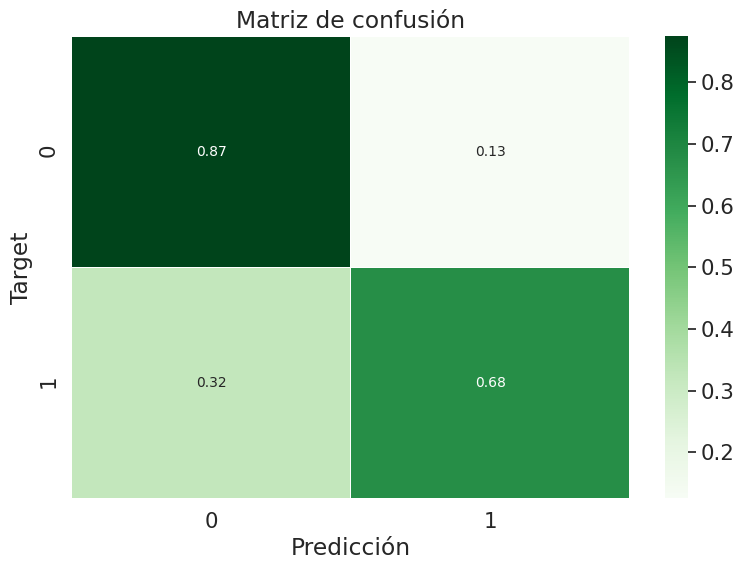

In [64]:
from lightgbm import LGBMClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


LGBM = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(LGBM, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accu: %.3f (%.6f)' % (np.mean(n_scores), np.std(n_scores)))

#Fit
LGBM = LGBMClassifier()
LGBM.fit(X_train, y_train)

#Predicciones
y_pred = LGBM.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)


# 2. XGBoost - TEXT

In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


#Entrenamiento
alg = XGBClassifier(learning_rate=0.1, n_estimators=20, max_depth=5,
                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

alg.fit(X_train, y_train, eval_metric='auc')

#Predicciones
y_pred = alg.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

# 3.  Random Forest Classifier - TEXT

In [ ]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
RFC = RandomForestClassifier(n_estimators=500, max_depth=131, class_weight = 'balanced',
                             criterion='entropy', max_features='auto', n_jobs=-1)


RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

#Features importances
#features = np.array(X.columns)
importances = RFC.feature_importances_

'''

#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [100, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9,11, 13],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)

'''
print('')

# 4. Regresión Logística - TEXT

In [ ]:
from sklearn.model_selection import cross_val_score

X_train = train_df['text_clean']
y_train = train_df['target']

X_test = test_df['text_clean']


# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Entrenamiento

LR = LogisticRegression(C=2, n_jobs=-1)
LR.fit(X_train, y_train)


#Métricas
y_pred = LR.predict(X_test)

# Secuencia [0, 1]
#pred = np.argmax(pred, axis=1)
resultados(y_pred, test_df)

#Feature estimator
eli5.show_weights(estimator=LR,feature_names= list(count_vect.get_feature_names()),top=(20, 20))

# 5. KNN - TEXT

In [ ]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 79, metric='minkowski')
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
mostrar_metricas(y_test, y_pred)


#Buscando un K 'bueno'
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k, metric='minkowski')
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()



# 6. Multinomial NB - TEXT

In [ ]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred = MNB.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)